<h1><center style="color:white;background:blue;border-radius:0px 25px;padding:25px">Credit Card Approval dataset</center></h1>

<ol>
    <li><a href="#understand">Understanding data</a></li>
    <li><a href="#cleaning">data Cleaning</a></li>
    <li><a href="#viz">data Visualization</a></li>
    <li><a href="#prep">data Preparation</a></li>
    <li><a href="#model">Machine Learning Model</a></li>
    <li><a href="#tune">Hyperparameter tuning</a></li>
</ol>

# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

<h1><center id="understand" style="color:white;background:blue;border-radius:25px 0px;padding:25px">understanding the data</center></h1>

In [4]:
# get columns name from columns file
with open('../input/column-names/Columns.txt', 'r') as f:
    lines = f.readlines()
    columns = [i.split()[0] for i in lines]
f.close()

In [5]:
# read df and put columns name
df = pd.read_csv('../input/cc-approvals/cc_approvals.data', names=columns)
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    object 
 1   Age             690 non-null    object 
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    object 
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


<h1><center id="cleaning" style="color:white;background:blue;border-radius:25px 0px;padding:25px">data Cleaning</center></h1>

In [7]:
df['Gender'].value_counts()

b    468
a    210
?     12
Name: Gender, dtype: int64

## Replace ? with NaN in all df

In [8]:
df.replace('?', np.nan, inplace=True)

In [9]:
# convert age to float
df['Age'] = df['Age'].astype('float')

## Check null values

In [10]:
df.isna().sum()

Gender            12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode           13
Income             0
Approved           0
dtype: int64

In [11]:
df['ZipCode'].value_counts()[:10]

00000    132
00120     35
00200     35
00160     34
00100     30
00080     30
00280     22
00180     18
00140     16
00240     14
Name: ZipCode, dtype: int64

- ZipCode can help us understand more about df and insights but after research, it seems to be incorrect

In [12]:
df.drop('ZipCode', axis=1, inplace=True)

In [13]:
obj_cols = df.columns[df.dtypes == 'object']
for i in obj_cols:
    print(f'{i}')
    print(df[i].unique())
    print('-'*30)

Gender
['b' 'a' nan]
------------------------------
Married
['u' 'y' nan 'l']
------------------------------
BankCustomer
['g' 'p' nan 'gg']
------------------------------
EducationLevel
['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j' nan]
------------------------------
Ethnicity
['v' 'h' 'bb' 'ff' 'j' 'z' nan 'o' 'dd' 'n']
------------------------------
PriorDefault
['t' 'f']
------------------------------
Employed
['t' 'f']
------------------------------
DriversLicense
['f' 't']
------------------------------
Citizen
['g' 's' 'p']
------------------------------
Approved
['+' '-']
------------------------------


## fill missing values

In [14]:
num_cols = df.columns[df.dtypes != 'object']
num_cols

Index(['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income'], dtype='object')

In [15]:
obj_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = KNNImputer(n_neighbors=3)

In [16]:
df[obj_cols] = obj_imputer.fit_transform(df[obj_cols])
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [17]:
# replace +, - to 1, 0
df['Approved'].replace({'+':1, '-':0}, inplace=True)

In [18]:
df['Income'].value_counts()[:5]

0.0       295
1.0        29
500.0      10
1000.0     10
2.0         9
6.0         8
5.0         8
Name: Income, dtype: int64

In [19]:
df[df['Income'] == 0]

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.250,t,t,1.0,f,g,0.0,1
4,b,20.17,5.625,u,g,w,v,1.710,t,f,0.0,f,s,0.0,1
5,b,32.08,4.000,u,g,m,v,2.500,t,f,0.0,t,g,0.0,1
10,b,22.08,0.830,u,g,c,h,2.165,f,f,0.0,t,g,0.0,1
12,a,38.25,6.000,u,g,k,v,1.000,t,f,0.0,t,g,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
668,b,30.33,0.500,u,g,d,h,0.085,f,f,0.0,t,s,0.0,0
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0.0,f,g,0.0,0
684,b,40.58,3.290,u,g,m,v,3.500,f,f,0.0,t,s,0.0,0
685,b,21.08,10.085,y,p,e,h,1.250,f,f,0.0,f,g,0.0,0


- In this case we need to ask business if Income equal 0 is true or miss info (For now let it true value)

### let's check again info and describe of the df

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    object 
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    object 
 4   BankCustomer    690 non-null    object 
 5   EducationLevel  690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    object 
 9   Employed        690 non-null    object 
 10  CreditScore     690 non-null    float64
 11  DriversLicense  690 non-null    object 
 12  Citizen         690 non-null    object 
 13  Income          690 non-null    float64
 14  Approved        690 non-null    int64  
dtypes: float64(5), int64(1), object(9)
memory usage: 81.0+ KB


- Age with float values maybe it's hashing value or garbage we need to ask business for this case (let it as it)

In [21]:
df.describe()

,Age,Debt,YearsEmployed,CreditScore,Income,Approved
count,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000
mean,31.561425,4.758725,2.223406,2.40000,1017.385507,0.444928
std,11.879281,4.978163,3.346513,4.86294,5210.102598,0.497318
min,13.750000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,22.670000,1.000000,0.165000,0.00000,0.000000,0.000000
50%,28.540000,2.750000,1.000000,0.00000,5.000000,0.000000
75%,38.065000,7.207500,2.625000,3.00000,395.500000,1.000000
max,80.250000,28.000000,28.500000,67.00000,100000.000000,1.000000


- No negative values
- There are outliers

## Outliers

- Let's use *QIR*

In [22]:
num_cols

Index(['Age', 'Debt', 'YearsEmployed', 'CreditScore', 'Income'], dtype='object')

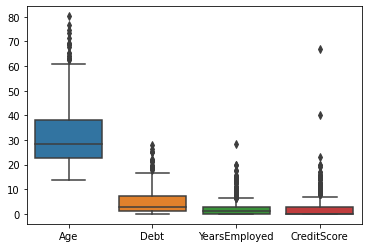

In [23]:
attributes = ['Age','Debt','YearsEmployed', 'CreditScore']
sns.boxplot(data = df[attributes]);

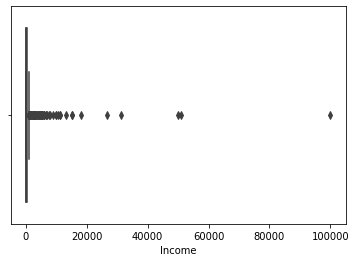

In [24]:
sns.boxplot(data=df, x='Income');

### Remove Outliers

In [25]:
len(df)

690

In [26]:
def outlier(df, col):
    Q1, Q3 = np.quantile(df[col], [0.0, 0.80])
    IQR = Q3 - Q1
    min = Q1 - IQR*1.5
    max = Q3 + IQR*1.5
    return df[(df[col] >= min) & (df[col] <= max)]

In [27]:
for i in num_cols:
    df = outlier(df, i)

In [28]:
len(df)

548

## Duplicate df

In [29]:
df[df.duplicated()]

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved


- No duplicate df

In [30]:
df['Gender'].value_counts()

b    380
a    168
Name: Gender, dtype: int64

### Making some new features to understand more and useful for business

In [31]:
df['Age'].min(), df['Age'].max()

(13.75, 80.25)

#### Age category (Teen, YoungMan, Adult, Old) of the person

In [32]:
def ageLevel(x):
    if x < 18:
        return 'Teen'
    elif x < 22:
        return 'YoungMan'
    elif x < 40:
        return 'Adult'
    else:
        return 'Old'

In [33]:
df['AgeLevel'] = df['Age'].apply(lambda x: ageLevel(x))
df['AgeLevel'].value_counts()

Adult       327
YoungMan     99
Old          89
Teen         33
Name: AgeLevel, dtype: int64

Another Way

In [34]:
def levels(x,Values,categories):
    x = float(x)
    for value,category in zip(Values,categories):
        if x < value : return category
        
df['AgeLevel']  = df['Age'].apply(lambda x : levels(x,[18,22,40,81] ,['Teen','YoungMan','Adult','Old']))

In [35]:
df['AgeLevel'].value_counts()

Adult       327
YoungMan     99
Old          89
Teen         33
Name: AgeLevel, dtype: int64

#### Dept category (Poor, Medium, Good)

In [36]:
df['Debt'].min(), df['Debt'].max()

(0.0, 19.0)

In [37]:
df['DebtLevel'] = df['Debt'].apply(lambda x : levels(x,[5,15,30] , ['Poor Debt','Medium Debt','Good Debt']))
df['DebtLevel'].value_counts()

Poor Debt      378
Medium Debt    162
Good Debt        8
Name: DebtLevel, dtype: int64

#### Years of Employed category (Poor, Medium, Good)

In [38]:
df['YearsEmployed'].min(), df['YearsEmployed'].max()

(0.0, 8.665)

In [39]:
df['YearsEmployedLevel']  = df['YearsEmployed'].apply(lambda x : levels(x,[1,5,30],['Low Experience','Medium Experience','Good Experience']))
df['YearsEmployedLevel'].value_counts()

Low Experience       294
Medium Experience    206
Good Experience       48
Name: YearsEmployedLevel, dtype: int64

#### Credit Score category (Poor, Medium, Good)

In [40]:
df['CreditScore'].min(), df['CreditScore'].max()

(0.0, 10.0)

In [41]:
df['CreditScoreLevel']  = df['CreditScore'].apply(lambda x : levels(x,[3,7, df['CreditScore'].max()+1],
             ['Poor Credit','Medium Credit','Good Credit']))
df['CreditScoreLevel'].value_counts()         

Poor Credit      456
Medium Credit     66
Good Credit       26
Name: CreditScoreLevel, dtype: int64

#### Income category (Poor, Medium, Good)

In [42]:
df['Income'].min(), df['Income'].max()

(0.0, 1210.0)

In [43]:
df['IncomeLevel']  = df['Income'].apply(lambda x : levels(x,[300,1000,100001], ['Poor Income','Medium Income','Good Income']))
df['IncomeLevel'].value_counts()    

Poor Income      456
Medium Income     76
Good Income       16
Name: IncomeLevel, dtype: int64

<h1><center id="viz" style="color:white;background:blue;border-radius:25px 0px;padding:25px">data Visualization</center></h1>

In [44]:
def CPlot(feature) : 
    global df
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x=feature, data=df,facecolor=(0, 0, 0, 0),
                  linewidth=5,edgecolor=sns.color_palette("dark", 3))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

def KPlot(feature,Limit=0) : 
    global df
    fig, ax = plt.subplots(figsize=(10,6))
    if Limit == 0 : 
        sns.kdeplot(df[feature], shade=True)
    else : 
        Data = df[df[feature]<=Limit]
        sns.kdeplot(Data[feature], shade=True)

def Pie(feature,Limit=20) : 
    global df
    fig, ax = plt.subplots(figsize=(10,6))
    plt.pie(df[feature].value_counts()[:Limit],labels=list(
        df[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(df[feature].value_counts()[:Limit]))] )
    plt.show()     
    
def SelectedGenderPie(feature,Limit=10) : 
    global df
    fig, ax = plt.subplots(figsize=(15,4))
    
    plt.subplot(1,2,1)
    plt.title('Gender A')
    Data = df[df['Gender']=='a']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
  
    plt.subplot(1,2,2)
    plt.title('Gender B')
    Data = df[df['Gender']=='b']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [
            0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
    plt.show()        
    
def SelectedApprovedPie(feature,Limit=10) : 
    global df
    fig, ax = plt.subplots(figsize=(15,4))
    
    plt.subplot(1,2,1)
    plt.title('Approved')
    Data = df[df['Approved']==1]
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
  
    plt.subplot(1,2,2)
    plt.title('Not Approved')
    Data = df[df['Approved']==0]
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
    plt.show()        
    
def SelectedAgePie(feature,Limit=10) : 
    global df
    fig, ax = plt.subplots(figsize=(15,4))
    
    plt.subplot(1,4,1)
    plt.title('Teen')
    Data = df[df['AgeLevel']=='Teen']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,
            explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
  
    plt.subplot(1,4,2)
    plt.title('YoungMan')
    Data = df[df['AgeLevel']=='YoungMan']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(
        Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )

    plt.subplot(1,4,3)
    plt.title('Adult')
    Data = df[df['AgeLevel']=='Adult']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )

    plt.subplot(1,4,4)
    plt.title('Old')
    Data = df[df['AgeLevel']=='Old']
    plt.pie(Data[feature].value_counts()[:Limit],labels=list(Data[feature].value_counts()[:Limit].index),
        autopct ='%1.2f%%' , labeldistance = 1.1,explode = [0.05 for i in range(len(Data[feature].value_counts()[:Limit]))] )
    plt.show()     
    

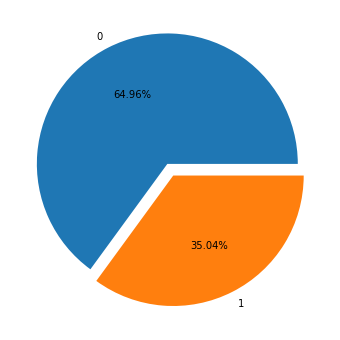

In [45]:
Pie('Approved')

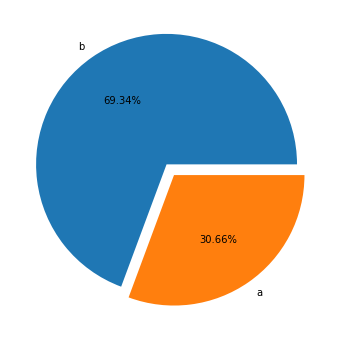

In [46]:
Pie('Gender')

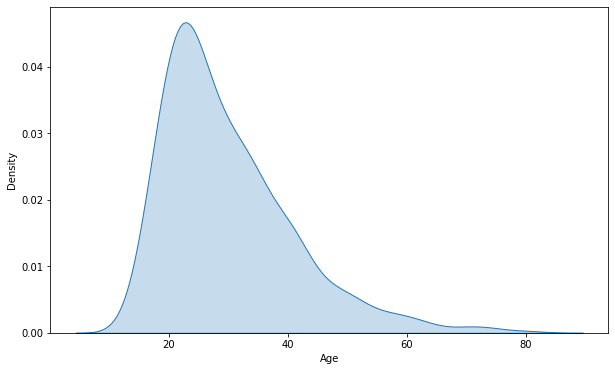

In [47]:
KPlot('Age')

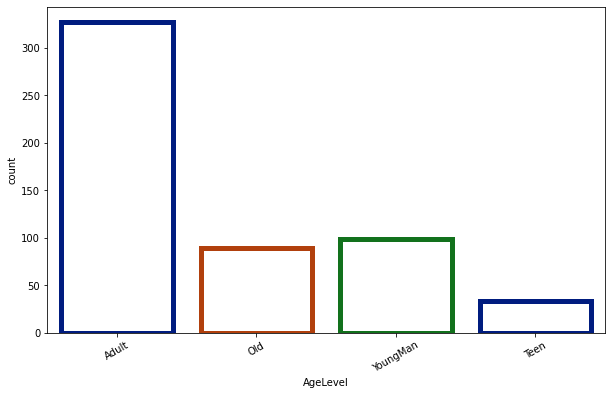

In [48]:
CPlot('AgeLevel')

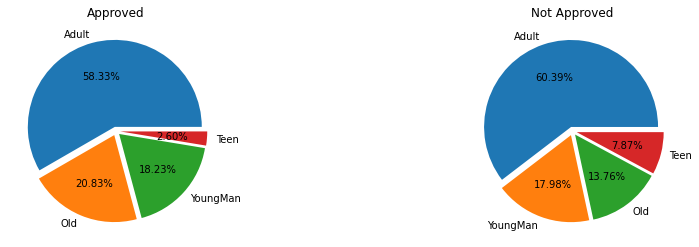

In [49]:
SelectedApprovedPie('AgeLevel')

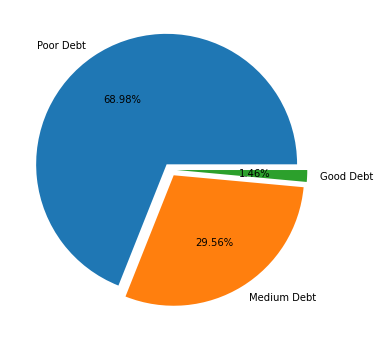

In [50]:
Pie('DebtLevel')

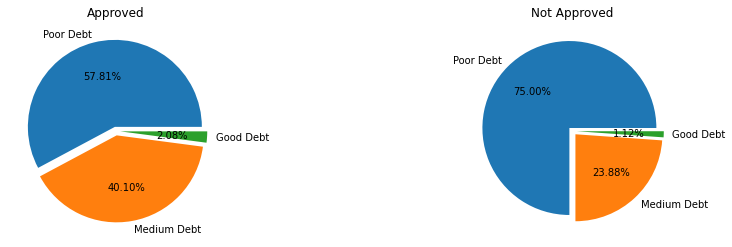

In [51]:
SelectedApprovedPie('DebtLevel')

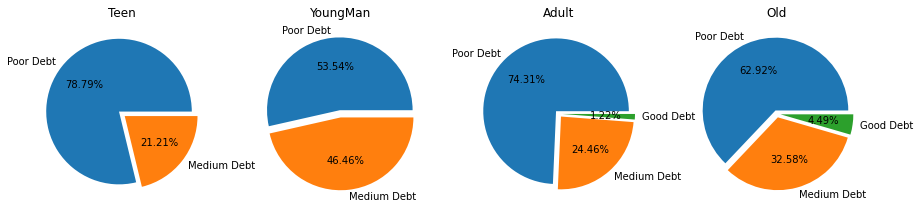

In [52]:
SelectedAgePie('DebtLevel')

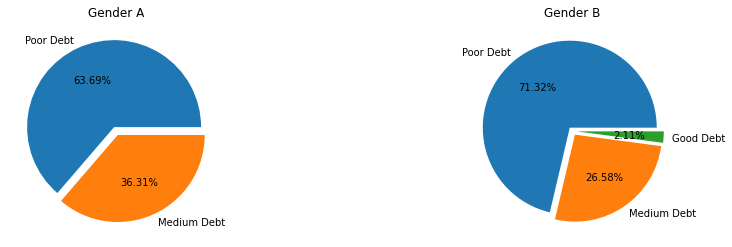

In [53]:
SelectedGenderPie('DebtLevel')

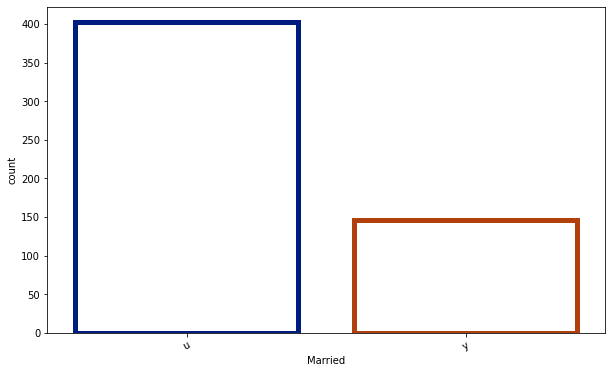

In [54]:
CPlot('Married')

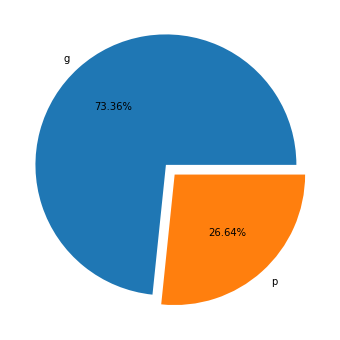

In [55]:
Pie('BankCustomer')

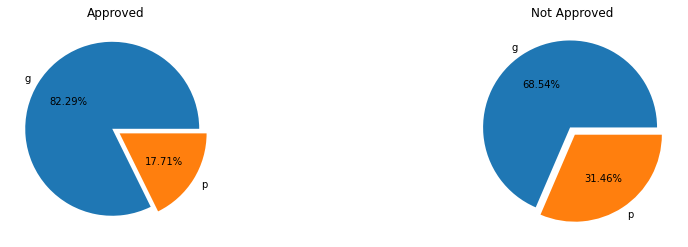

In [56]:
SelectedApprovedPie('BankCustomer')

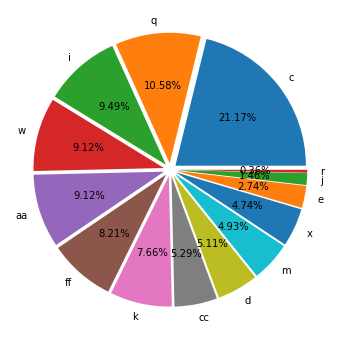

In [57]:
Pie('EducationLevel')

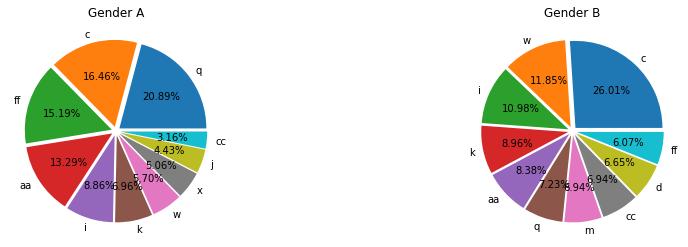

In [58]:
SelectedGenderPie('EducationLevel')

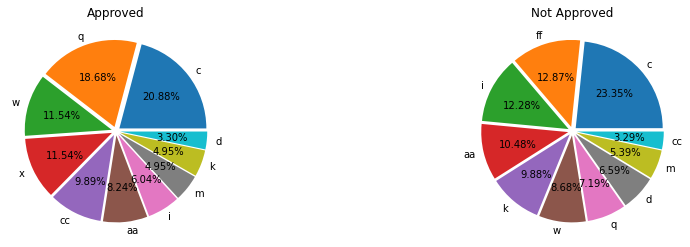

In [59]:
SelectedApprovedPie('EducationLevel')

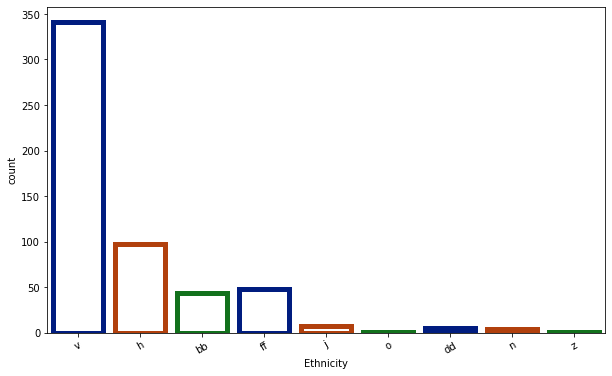

In [60]:
CPlot('Ethnicity')

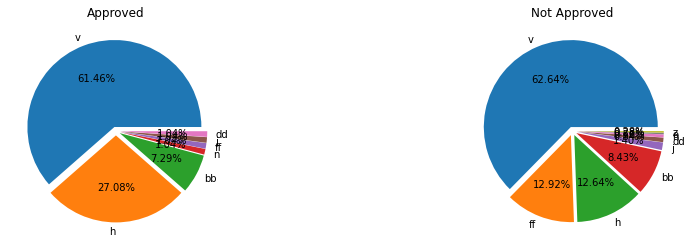

In [61]:
SelectedApprovedPie('Ethnicity')

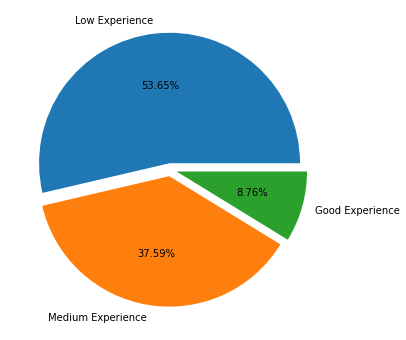

In [62]:
Pie('YearsEmployedLevel')

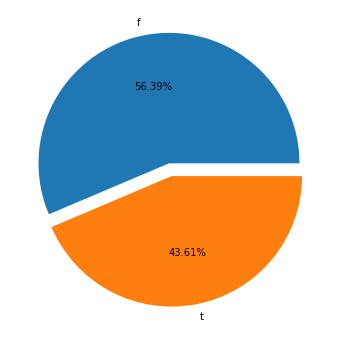

In [63]:
Pie('PriorDefault')

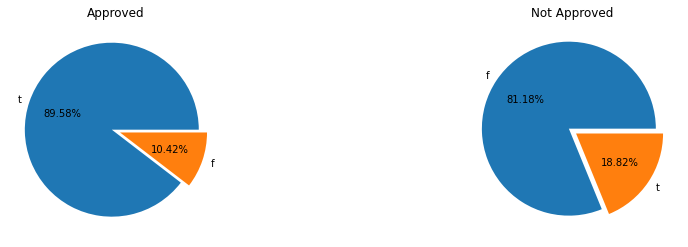

In [64]:
SelectedApprovedPie('PriorDefault')

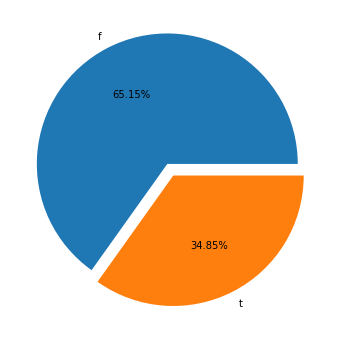

In [65]:
Pie('Employed')

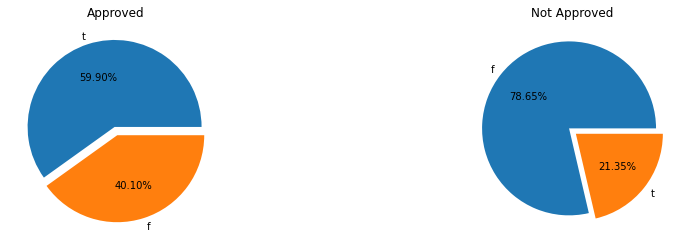

In [66]:
SelectedApprovedPie('Employed')

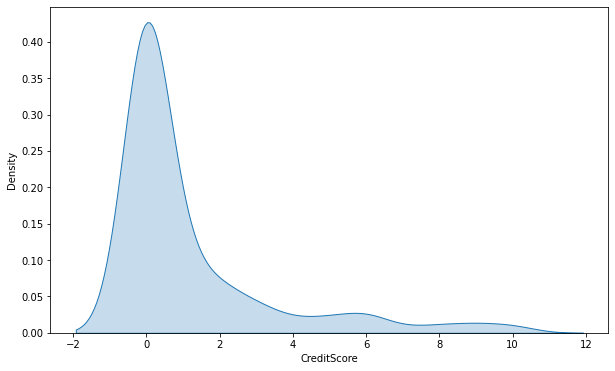

In [67]:
KPlot('CreditScore')

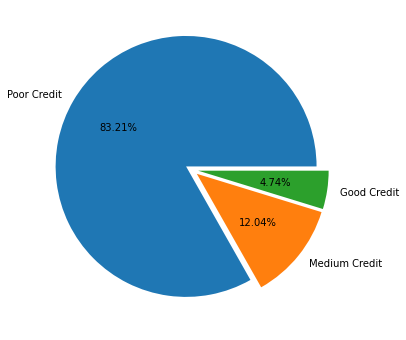

In [68]:
Pie('CreditScoreLevel')

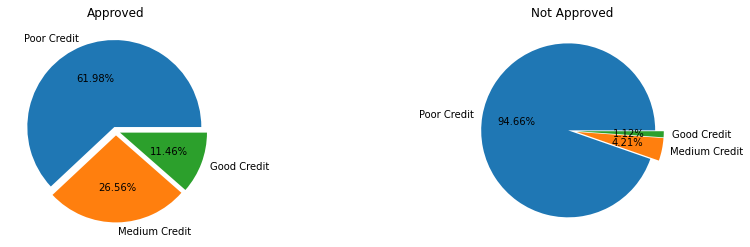

In [69]:
SelectedApprovedPie('CreditScoreLevel')

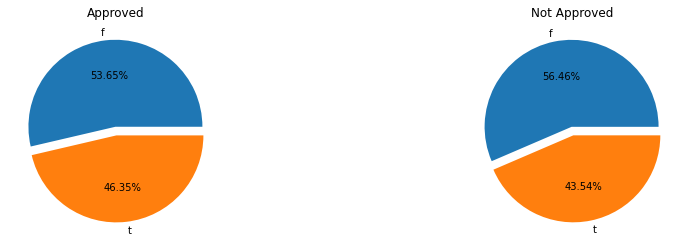

In [70]:
SelectedApprovedPie('DriversLicense')

# Note
- All new features in our data now not necessary to use them it depend on your case

<h1><center id="prep" style="color:white;background:blue;border-radius:25px 0px;padding:25px">data Preparation</center></h1>

In [71]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved,AgeLevel,DebtLevel,YearsEmployedLevel,CreditScoreLevel,IncomeLevel
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,0.0,1,Adult,Poor Debt,Medium Experience,Poor Credit,Poor Income
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,560.0,1,Old,Poor Debt,Medium Experience,Medium Credit,Medium Income
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,824.0,1,Adult,Poor Debt,Medium Experience,Poor Credit,Medium Income
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,3.0,1,Adult,Poor Debt,Medium Experience,Medium Credit,Poor Income
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,0.0,1,YoungMan,Medium Debt,Medium Experience,Poor Credit,Poor Income


In [72]:
df.drop(columns=['AgeLevel', 'DebtLevel', 'YearsEmployedLevel', 'CreditScoreLevel',	'IncomeLevel'], axis=1, inplace=True)

In [73]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1.0,f,g,0.0,1
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6.0,f,g,560.0,1
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0.0,f,g,824.0,1
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5.0,t,g,3.0,1
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0.0,f,s,0.0,1


In [74]:
list(obj_cols)

['Gender',
 'Married',
 'BankCustomer',
 'EducationLevel',
 'Ethnicity',
 'PriorDefault',
 'Employed',
 'DriversLicense',
 'Citizen',
 'Approved']

## Label Encoding

In [75]:
encoder = LabelEncoder()

In [76]:
def ApplyEncoder(OriginalColumn) : 
    global df
    Encoder = LabelEncoder()
    Encoder.fit(df[OriginalColumn])
    return Encoder.transform(df[OriginalColumn])

In [77]:
for col in obj_cols:
    df[col] = ApplyEncoder(col)

In [78]:
df.head()

,Gender,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,1,30.83,0.000,0,0,12,7,1.25,1,1,1.0,0,0,0.0,1
1,0,58.67,4.460,0,0,10,3,3.04,1,1,6.0,0,0,560.0,1
2,0,24.50,0.500,0,0,10,3,1.50,1,0,0.0,0,0,824.0,1
3,1,27.83,1.540,0,0,12,7,3.75,1,1,5.0,1,0,3.0,1
4,1,20.17,5.625,0,0,12,7,1.71,1,0,0.0,0,2,0.0,1


## Split

In [79]:
x = df.drop('Approved', axis=1)
y = df['Approved']

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, stratify=y)

## Scale

In [81]:
scale = StandardScaler()

In [82]:
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

<h1><center id="model" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Model</center></h1>

In [83]:
model = XGBClassifier(use_label_encoder=False)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [84]:
print("score in training data : ", model.score(x_train, y_train))
y_pred = model.predict(x_test)
print("score in testing data : ", accuracy_score(y_test, y_pred))
print("F1 score ", f1_score(y_test, y_pred))

score in training data :  1.0
score in testing data :  0.8181818181818182
F1 score  0.7297297297297296


- Let's solve overfitting problem

 <h1><center id="tune" style="color:white;background:blue;border-radius:25px 0px;padding:25px">Hyperparameter tuning</center></h1>

In [85]:
model = XGBClassifier(use_label_encoder=False)

In [86]:
params = [
    {'n_estimators':[100, 150, 200, 250], 'max_depth':[5, 6, 7], 'learning_rate':[0.01, 0.03]}
]

In [87]:
GRD_search = GridSearchCV(estimator=model,param_grid=params, scoring='f1', n_jobs=-1, cv=10)

In [88]:
GRD_search.fit(x_train,y_train)

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_c...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                  

In [89]:
GRD_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [90]:
GRD_search.best_score_

0.8121482942453955

In [91]:
model = GRD_search.best_estimator_

In [92]:
print("score in training data : ", model.score(x_train, y_train))
y_pred = model.predict(x_test)
print("score in testing data : ", accuracy_score(y_test, y_pred))
print("F1 score ", f1_score(y_test, y_pred))

score in training data :  0.9452054794520548
score in testing data :  0.8727272727272727
F1 score  0.8055555555555556


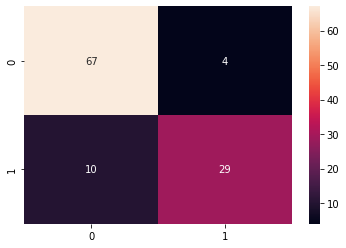

In [93]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='1');